# CE888 Data Science and Decision Making
## Final Project
### Evolutionary Strategies for Domain Adaptation
### MNIST-M Dataset
### 1702557
### Tanya Ramirez

### Important considerations
Before to start, the BSDS500 dataset must be downloaded in the same folder as this file. This dataset can be found in [here](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/resources.html#bsds500). 

### Observations from the dataset
##### MNIST-M
In this case and in order to create the target set, the digits from the MNIST set were blended ober patches randomly selected from BSDS500, so de difference between the source and target will be that the target are digits blended over a non-uniform background. Depending on where the code is runed in order to generate the MNIST-M set, there can be a problem with the memory o generate the pickle folder.

### Structure of the code
In a brief, this is the structure of the above code:
* In first place, the source (MNIST dataset) and target (MNIST-M dataset) data are created.
* Then, the domain adaptation model is created where the input is the data that is included in a neural network for which the ouput is features. Then, 
* Finally, the previous model is applied on the source and target datasets previously defined.

### MNIST-M data set
Thee code used to create the domain and source data were incorporated from [Ganin, Yaroslav, et al. "Domain-adversarial training of neural networks." The Journal of Machine Learning Research 17.1 (2016): 2096-2030.](https://github.com/pumpikano/tf-dann/blob/master/create_mnistm.py)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tarfile
import os
import pickle as pkl
import numpy as np
import skimage
import skimage.io
import skimage.transform
import tensorflow as tf

np.random.seed(1337) 

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data')

BST_PATH = 'BSR_bsds500.tgz'

rand = np.random.RandomState(33)

f = tarfile.open(BST_PATH)
train_files = []

for name in f.getnames():
    if name.startswith('BSR/BSDS500/data/images/train/'):
        train_files.append(name)
        
print('Loading BSR training images')
background_data = []
for name in train_files:
    try:
        fp = f.extractfile(name)
        bg_img = skimage.io.imread(fp)
        background_data.append(bg_img)
    except:
        continue
        
def compose_image(digit, background):
    """
    Difference-blend a digit and a random patch from a background image.
    """
    w, h, _ = background.shape
    dw, dh, _ = digit.shape
    x = np.random.randint(0, w - dw)
    y = np.random.randint(0, h - dh)

    bg = background[x:x+dw, y:y+dh]
    return np.abs(bg - digit).astype(np.uint8)

def mnist_to_img(x):
    """
    Binarize MNIST digit and convert to RGB.
    """
    x = (x > 0).astype(np.float32)
    d = x.reshape([28, 28, 1]) * 255
    return np.concatenate([d, d, d], 2)

def create_mnistm(X):
    """
    Give an array of MNIST digits, blend random background patches to
    build the MNIST-M dataset as described in
    http://jmlr.org/papers/volume17/15-239/15-239.pdf
    """
    X_ = np.zeros([X.shape[0], 28, 28, 3], np.uint8)
    for i in range(X.shape[0]):

        if i % 1000 == 0:
            print('Processing example', i)

        bg_img = rand.choice(background_data)
        d = mnist_to_img(X[i])
        d = compose_image(d, bg_img)
        X_[i] = d

    return X_

print('Building training set...')
train = create_mnistm(mnist.train.images)
print('Building testing set...')
test = create_mnistm(mnist.test.images)
print('Building validation set...')
valid = create_mnistm(mnist.validation.images)

"""
Save dataset as pickle. 
"""
# Depending on where is runned the code, there can be a problem with the memory. 
with open('mnistm_data.pkl', 'wb') as f:
    pkl.dump({ 'train': train, 'test': test, 'valid': valid }, f, pkl.HIGHEST_PROTOCOL)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Loading BSR training images
Building training set...
Processing example 0
Processing example 1000
Processing example 2000
Processing example 3000
Processing example 4000
Processing example 5000
Processing example 6000
Processing example 7000
Processing example 8000
Processing example 9000
Processing example 10000
Processing example 11000
Processing example 12000
Processing example 13000
Processing example 14000
Processing example 15000
Processing example 16000
Processing example 17000
Processing example 18000
Processing example 19000
Processing example 20000
Processing example 21000
Processing example 22000
Processing example 23000
Processing example 24000
Processing example 25000
Processing example 26000
Processing example 27000
Processing example 28000
Processing example 29000
Processing examp

In [3]:
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot = True)

""" 
Process MNIST - Source data 
"""
mnist_train = (mnist.train.images > 0).reshape(55000, 28, 28, 1).astype(np.uint8) * 255
mnist_train = np.concatenate([mnist_train, mnist_train, mnist_train], 3)

mnist_test = (mnist.test.images > 0).reshape(10000, 28, 28, 1).astype(np.uint8) * 255
mnist_test = np.concatenate([mnist_test, mnist_test, mnist_test], 3)

mnist_valid = (mnist.validation.images > 0).reshape(mnist.validation.images.shape[0], 28, 28, 1).astype(np.uint8) * 255
mnist_valid = np.concatenate([mnist_valid, mnist_valid, mnist_valid], 3)

""" 
Load MNIST-M - Target data 
"""
mnistm = pkl.load(open('mnistm_data.pkl', 'rb'))
mnistm_train = mnistm['train'] 
mnistm_test = mnistm['test'] 
mnistm_valid = mnistm['valid']

""" 
Compute pixel mean for normalizing data 
"""
pixel_mean = np.vstack([mnist_train, mnistm_train]).mean((0, 1, 2))

""" 
Define labels from MNIST set - Source dataset 
"""
label_train = np.asarray([np.argwhere(i)[0][0] for i in mnist.train.labels])
label_validation = np.asarray([np.argwhere(i)[0][0] for i in mnist.validation.labels])
label_test = np.asarray([np.argwhere(i)[0][0] for i in mnist.test.labels])


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


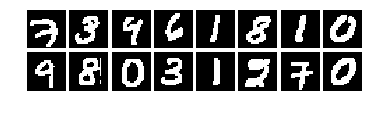

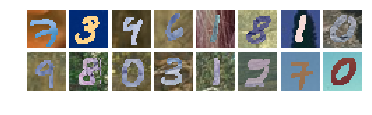

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def imshow_grid(images, shape=[2, 8]):
    """Plot images in a grid of a given shape."""
    fig = plt.figure(1)
    grid = ImageGrid(fig, 111, nrows_ncols=shape, axes_pad=0.05)

    size = shape[0] * shape[1]
    for i in range(size):
        grid[i].axis('off')
        grid[i].imshow(images[i])  # The AxesGrid object work as a list of axes.

    plt.show()

imshow_grid(mnist_train)
imshow_grid(mnistm_train)

In [28]:
""""
Normalize MNIST and MNIST-M
"""
pixel_mean = np.vstack([mnist_train, mnistm_train]).mean((0, 1, 2))
mnist_train = (mnist_train - pixel_mean) / 255.
mnistm_train = (mnistm_train - pixel_mean) / 255.

In [29]:
"""
Run this to run the code in a small sample only.
"""
# Small sample to run faster the model
#SAMPLE = 200

#mnist_tr_0 = mnist_train[:SAMPLE]
#label_tr_0 = label_train[:SAMPLE]
#mnist_val_0 = mnist_valid[:SAMPLE]
#label_val_0 = label_validation[:SAMPLE]

#mnistm_tr_0 = mnistm_train[:SAMPLE]
mnistm_val_0 = mnistm_valid[:SAMPLE]

In [30]:
""""
Define source(MNIST) and target(MNIST-M) data and their correspondent labels.
"""
# To work with a small sample
#source = [(mnist_tr_0, label_tr_0),(mnist_val_0, label_val_0)]
#target = [(mnistm_tr_0, label_tr_0),(mnistm_val_0, label_val_0)]

# To work with the complete datasets
source = [(mnist_train, label_train),(mnist_valid, label_validation)]
target = [(mnistm_train, label_train),(mnistm_valid, label_validation)]

In [31]:
""""
Parameters for the SNES
"""
# Number of the different sets of weights ask() should return for evaluation
POPULATION_SIZE = 10
# Number of times we will loop over ask()/tell() - Generations
GENERATIONS = 35 #35 generations is a good result

In [32]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from timeit import default_timer as timer

import numpy as np
import pylab
import seaborn as sns
import pandas as pd

from keras_helper import NNWeightHelper
from snes import SNES

In [33]:
"""
Separate from source and target in X (images) and Y (labels).
"""
# Source domain
source_tr_X = np.asarray(source[0][0])
source_tr_Y = np.asarray(source[0][1])
        
source_val_X = np.asarray(source[1][0])
source_val_Y = np.asarray(source[1][1])

# Target domain
target_tr_X = np.asarray(target[0][0])
target_tr_Y = np.asarray(target[0][1])
        
target_val_X = np.asarray(target[1][0])
target_val_Y = np.asarray(target[1][1])

# Combined dataset for domain classifier
combined_tr_X = np.concatenate((source_tr_X, target_tr_X), axis = 0)
combined_tr_Y = np.concatenate((np.zeros(source_tr_X.shape[0]), np.ones(target_tr_X.shape[0])), axis = 0)

combined_val_X = np.concatenate((source_val_X, target_val_X), axis = 0)
combined_val_Y = np.concatenate((np.zeros(source_val_X.shape[0]), np.ones(target_val_X.shape[0])), axis = 0)

input_shape = source_tr_X.shape[1:]
        

In [34]:
"""
Create neural network to train the random forest.
"""
model = Sequential()
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D())
model.add(Conv2D(48, kernel_size = (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(8, activation = 'relu')) # Parameter to tune: features for the model

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 48)        13872     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 48)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 9608      
Total params: 24,376
Trainable params: 24,376
Non-trainable params: 0
_________________________________________________________________


In [35]:
"""
Functions to use for the creation of the model. 
"""
def train_classifier(model, x, y):
    x_features = model.predict(x)
    clf = RandomForestClassifier(n_estimators = 5) # Parameter to tune: number of estimators
    clf.fit(x_features, y)   
    #y_pred = clf.predict(x_features)
    return clf #, y_pred

def predict_classifier(clf, x):
    x_features = model.predict(x)
    y = clf.predict(x_features)
    return y

def score_snes(label_accuracy, domain_accuracy):
    score_snes = 0.95*label_accuracy + 0.05*domain_accuracy # Parameter to tune: weights of the score
    return score_snes


In [36]:
# For training of domain classifier 
random_domainTrain_indices = np.random.choice(a = list(range(combined_tr_X.shape[0])), size = 1024)
combined_domain_tr_X = combined_tr_X[random_domainTrain_indices]
combined_domain_tr_Y = combined_tr_Y[random_domainTrain_indices]

# For validation of domain classifier
random_domainValid_indices = np.random.choice(a = list(range(combined_val_X.shape[0])), size = 1024)
combined_domain_val_X = combined_val_X[random_domainValid_indices]
combined_domain_val_Y = combined_val_Y[random_domainValid_indices]

# For label validation
source_validation_indices = np.random.choice(a = list((range(source_val_X.shape[0]))), size = 1024)
val_X = source_val_X[source_validation_indices]
val_Y = source_val_Y[source_validation_indices]

"""
Non-trained accuracy for label and domain prediction.
"""
label_clf = train_classifier(model, source_tr_X, source_tr_Y)
label_pred = predict_classifier(label_clf, val_X)
label_accuracy = accuracy_score(val_Y, label_pred)

domain_clf = train_classifier(model, combined_domain_tr_X, combined_domain_tr_Y)
domain_pred = predict_classifier(domain_clf, combined_domain_val_X)
domain_accuracy = accuracy_score(combined_domain_val_Y, domain_pred)

print('Non-trained accuracy for label classifier is %0.4f and for the domain classifier is %0.4f'
      %(label_accuracy, domain_accuracy))

Non-trained accuracy for label classifier is 0.1064 and for the domain classifier is 0.4990


In [37]:
weight_modifier = NNWeightHelper(model)
weights = weight_modifier.get_weights()
print('Total weights to evolve:', len(weights))

snes = SNES(weights, 1, POPULATION_SIZE)
        
start = timer()
        
loss_score = []
loss_domain = []
loss_label = []

for i in range(GENERATIONS):
    new_weights = snes.ask()

    scores = []
    domain_accuracies = []
    label_accuracies = []

    """
    Retrain the RF with the new weights
    """
    for w in new_weights:
        weight_modifier.set_weights(w)
                
        # Train the label classifier: using only source domain
        label_clf = train_classifier(model, source_tr_X, source_tr_Y)
        # Predict with the label classifier on the source validation dataset
        label_predictions = predict_classifier(label_clf, val_X)
        label_accuracy = accuracy_score(val_Y, label_predictions)

        # Train the domain classifier in a mixed domain dataset
        domain_clf = train_classifier(model, combined_domain_tr_X, combined_domain_tr_Y)
        # Predict with the domain classifier
        domain_predictions = predict_classifier(domain_clf, combined_domain_val_X)
        domain_accuracy = accuracy_score(combined_domain_val_Y, domain_predictions)

        # Accuracy from domain classifier, label classifier and the score(fitness) for SNES
        scores.append(score_snes(label_accuracy, domain_accuracy))
        domain_accuracies.append(domain_accuracy)
        label_accuracies.append(label_accuracy)

        
    snes.tell(new_weights, scores)
    new_model = np.argmax(scores)
    print("Generation ", i + 1)
    print("Best model: Label accuracy of %0.4f, domain accuracy of %0.4f and overall score of %0.4f" 
                 %(label_accuracies[new_model], domain_accuracies[new_model], scores[new_model]))
                        
    l_score = 1 - scores[new_model]
    l_domain = 1 - domain_accuracies[new_model]
    l_label = 1 - label_accuracies[new_model]

    loss_score.append(l_score)
    loss_domain.append(l_domain)
    loss_label.append(l_label)
    
end = timer()

print(end - start)

Total weights to evolve: 24376
Step 1.0 : 0.20771484375 Best: 0.20771484375 10
Generation  1
Best model: Label accuracy of 0.1924, domain accuracy of 0.4990 and overall score of 0.2077
Step 2.0 : 0.19931640625 Best: 0.20771484375 10
Generation  2
Best model: Label accuracy of 0.1836, domain accuracy of 0.4980 and overall score of 0.1993
Step 3.0 : 0.18916015625000002 Best: 0.20771484375 10
Generation  3
Best model: Label accuracy of 0.1729, domain accuracy of 0.4990 and overall score of 0.1892
Step 4.0 : 0.2318359375 Best: 0.2318359375 10
Generation  4
Best model: Label accuracy of 0.2178, domain accuracy of 0.4990 and overall score of 0.2318
Step 5.0 : 0.194482421875 Best: 0.2318359375 10
Generation  5
Best model: Label accuracy of 0.1738, domain accuracy of 0.5869 and overall score of 0.1945
Step 6.0 : 0.15849609374999998 Best: 0.2318359375 10
Generation  6
Best model: Label accuracy of 0.1426, domain accuracy of 0.4609 and overall score of 0.1585
Step 7.0 : 0.197021484375 Best: 0.23

Accuracy of prediction of labels in source validation dataset is 0.1574
Accuracy of prediction of labels in target validation dataset is 0.1773
Accuracy of prediction of domain in both validation datasets is 0.4853


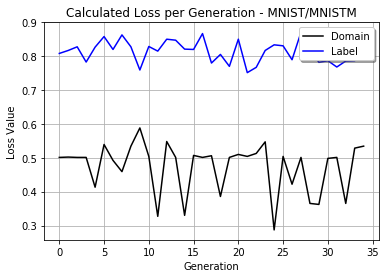

In [38]:
weight_modifier.set_weights(snes.center)

label_clf = train_classifier(model, source_tr_X, source_tr_Y)

random_domainTrain_indices = np.random.choice(a = list(range(combined_tr_X.shape[0])), size = combined_tr_X.shape[0]) 
all_domain_tr_X = combined_tr_X[random_domainTrain_indices]
all_domain_tr_Y = combined_tr_Y[random_domainTrain_indices]

domain_clf = train_classifier(model, all_domain_tr_X, all_domain_tr_Y)

random_domainValid_indices = np.random.choice(a = list(range(combined_val_X.shape[0])), size = combined_val_X.shape[0])
all_domain_testX = combined_val_X[random_domainValid_indices]
all_domain_testY = combined_val_Y[random_domainValid_indices]

source_label_predictions = predict_classifier(label_clf, source_val_X)
target_label_predictions = predict_classifier(label_clf, target_tr_X)
domain_predictions = predict_classifier(domain_clf, all_domain_testX)

# Evaluation in both datasets for label classifier and evaluation in a mix dataset for domain classifiers
print('Accuracy of prediction of labels in source validation dataset is %0.4f'% 
      (accuracy_score(source_val_Y, source_label_predictions)))
print('Accuracy of prediction of labels in target validation dataset is %0.4f'%
      (accuracy_score(target_tr_Y, target_label_predictions)))
print('Accuracy of prediction of domain in both validation datasets is %0.4f'%
      (accuracy_score(all_domain_testY, domain_predictions)))
        
# Plot of the losses in each generation
fig = pylab.figure()
ax = fig.add_subplot(111)
ax.grid(True)
ax.set_xlabel("Generation")
ax.set_ylabel("Loss Value")
ax.set_title("Calculated Loss per Generation - MNIST/MNISTM")

#ax.plot(loss_score, 'r', label = 'Score')
ax.plot(loss_domain, 'k', label = 'Domain')
ax.plot(loss_label, 'b', label = 'Label')
legend = ax.legend(loc = 'upper right', shadow = True)
#plt.savefig('mnistm_loss_generation.png')

pylab.show()